# Case Study 6: SPAM Detection Using Naive Bayes, Regression and Decision Tree Classifiers 
by Billy Nayden and Quynh Chau
MSDS 7333 Quantifying the World
Feb 15, 2021

# 1 Introduction 

The purpose of this case study is to build classifiers for categorizing emails as SPAM or normal using Naive Bayes, Random Forest and XgBoost.  Our email data is sourced from SpamAssassin and contain 9,353 emails already categorized as either  normal emails refered to as ham) and SPAM.  

# 2 Method

Data preparation involved an extensive multi-step process of unzipping the email folders from SpamAssassin, examining sample email messages to determine various parts of the email message anatomy that could be used as boundaries for separating specific components, splitting the email messages into specific components including body, header parts, removing email attachments, and finally, extracting the words (not case sensitive, exclusive of 1-letter word, blanks converted into spaces, and all punctuations including apostrophes in possessive noun in to "s") to be included sets of words per message and  word bags across all messages for building classifiers.

These tasks were carried out using the "grep" functionality in R along with sentinel phrases like blank lines, other MIME syntax (like "Content" and "Multi" to detect attachments) as well as user defined indices to locate where each type of email component begins and ends.  

Since the original email data were already categorized as SPAM or ham, wsing the bag of words aggregated from these messages, the frequencies of words in training data sets for ham and SPAM were estimated using conditional probabilities. Using these conditional probabilities, we then calculated the threshold for log likelihood ratio of the message as ham or SPAM based on the frequencies of these words in a given message.  These log likelihood estimatations were based on the error rates for three different classifiers:  Naive Bayes 5-fold CV with Laplace parameter tuning, Decision Tree using rpart with complexityval tuning and using train/test data split, Random Forest 3-fold CV and mtry parameter tuning and XgBoost 3-fold CV and nrunds, maxdepth, eta, and gamma parameter tuning.   


Reference for Methods: Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving. Chapter 3.  Deborah Nolan and Duncan Temple Lang. CRC Press: 2015.

# 3 Results

The BoxPlot below of Log Likelihood Ratio (LLR) for ham and SPAM classification based on frequencies of words in SPAM and ham emails showed a wide separation between ham and SPAM messages where ham messages have log likelihood ratios well below 0 whereas the SPAM messages have log likelihood ratios are above 0.  Moreover, the threshhold for Type I error/Type II Error is around LLR= -43.  


BoxPlot of Log Likelihood for ham and SPAM emails using 70:30 training/test splits for each category of email.

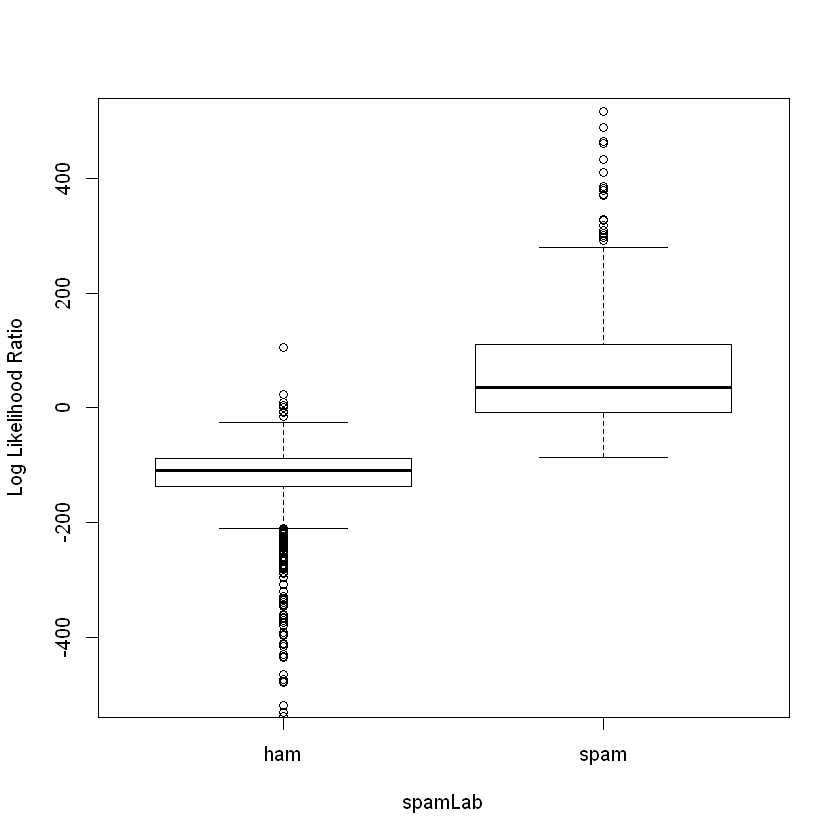

In [57]:
#pdf("SP_Boxplot.pdf", width = 6, height = 6)
spamLab = c("ham", "spam")[1 + testIsSpam]
boxplot(testLLR ~ spamLab, ylab = "Log Likelihood Ratio",
      #  main = "Log Likelihood Ratio for Randomly Chosen Test Messages",
        ylim=c(-500, 500))
#dev.off()

Type I error is defined as the probability of classifying Ham as SPAM;  Type II error is defined as classifying SPAM as ham.  These error rate and the respective log likelihood ratios are shown in the plot below for the training and test sets used to define the threshold for log likelihood based on frequencies of word occurence in an email.

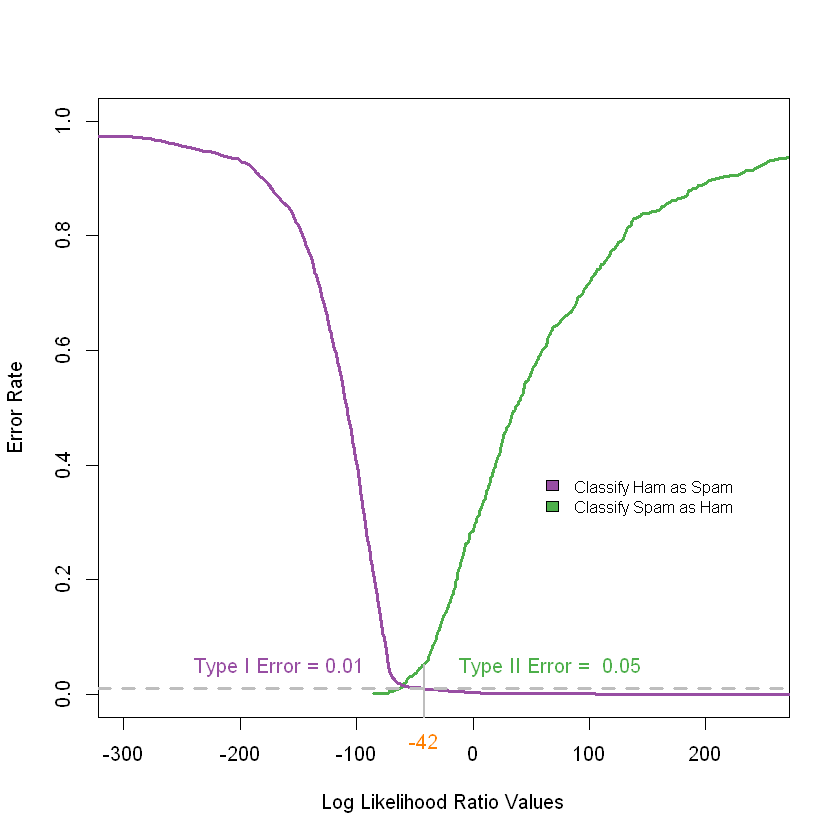

In [58]:
#pdf("LinePlotTypeI+IIErrors.pdf", width = 8, height = 6)

library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(xII$error ~ xII$values,  type = "l", col = cols[1], lwd = 3,
     xlim = c(-300, 250), ylim = c(0, 1),
     xlab = "Log Likelihood Ratio Values", ylab="Error Rate")
points(xI$error ~ xI$values, type = "l", col = cols[2], lwd = 3)
legend(x = 50, y = 0.4, fill = c(cols[2], cols[1]),
       legend = c("Classify Ham as Spam", 
                  "Classify Spam as Ham"), cex = 0.8,
       bty = "n")
abline(h=0.01, col ="grey", lwd = 3, lty = 2)
text(-250, 0.05, pos = 4, "Type I Error = 0.01", col = cols[2])

mtext(tau01, side = 1, line = 0.5, at = tau01, col = cols[3])
segments(x0 = tau01, y0 = -.50, x1 = tau01, y1 = t2, 
         lwd = 2, col = "grey")
text(tau01 + 20, 0.05, pos = 4,
     paste("Type II Error = ", round(t2, digits = 2)), 
     col = cols[1])

#dev.off()

In [4]:
#Classifier results 
Classifier <- c("NB", "RPart", "Random Forest", "XGBoost")
Type_I_Error <- c(0.03188,0.0340,0.0158, 0.1658)
Type_II_Error <- c(0.02481,0.1790,0.0097, 0.0086)
Param_Tuning <- c("cp =0.001 with f1 score = 0.96","complexityval = 0-.002","mtry 7 with f1 score = 0.98", "nrounds = 100, max_depth=11, eta = 0.1, gamma =1")
Comments <-c()
Results_Class <- data.frame(Classifier, Type_I_Error,Type_II_Error, Param_Tuning)
Results_Class
# 4 Conclusion

Classifier,Type_I_Error,Type_II_Error,Param_Tuning
<fct>,<dbl>,<dbl>,<fct>
NB,0.03188,0.02481,cp =0.001 with f1 score = 0.96
RPart,0.03400,0.17900,complexityval = 0-.002
Random Forest,0.01580,0.00970,mtry 7 with f1 score = 0.98
XGBoost,0.16580,0.00860,"nrounds = 100, max_depth=11, eta = 0.1, gamma =1"


The dataframe table above summarizes the performance results of four classifiers.  More detailed plots for parameter tuning can be found at the end of the Code Appendix below.

# 4 Conclusion

Based on Type I error criteria, Random Forest with 3-fold cross validation and rfgrid(mtry = 7) hyperparameter tuning yields the best results for correctly classifying Ham emails.  This model also performed better with a small Type II error.  XGBoost was the worst performing model for classifying Ham emails correctly.  However, it had the smallest Type II error. Naive Bayes (NB) and RPart both yielded close Type I Error but NB had a relatively smaller Type II error.  Overall, the best classifier for identifying ham as ham and Spam as Spam was Random Forest.

#  Appendix :  R Code

## Set working directories and reading in downloaded email folders from SpamAssassin

In [3]:
getwd()

[1] "C:/Users/WilliamNayden/Downloads"

In [5]:
setwd('C:/Users/WilliamNayden/Documents/MSDS/')

In [6]:
spamPath = "C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar"
list.files(path = paste(spamPath, "messages", sep = .Platform$file.sep))

[1] "easy_ham"   "easy_ham_2" "hard_ham"   "spam"       "spam_2"

In [7]:
head(list.files(path = paste(spamPath, "messages", "spam_2",
                             sep = .Platform$file.sep)))

dirNames = list.files(path = paste(spamPath, "messages", 
                      sep = .Platform$file.sep))
length(list.files(paste(spamPath, "messages", dirNames, 
                        sep = .Platform$file.sep)))

sapply(paste(spamPath, "messages", dirNames, 
             sep = .Platform$file.sep), 
       function(dir) length(list.files(dir)) )

fullDirNames = paste(spamPath, "messages", dirNames, 
                     sep = .Platform$file.sep)

[1] "00001.317e78fa8ee2f54cd4890fdc09ba8176"
[2] "00002.9438920e9a55591b18e60d1ed37d992b"
[3] "00003.590eff932f8704d8b0fcbe69d023b54d"
[4] "00004.bdcc075fa4beb5157b5dd6cd41d8887b"
[5] "00005.ed0aba4d386c5e62bc737cf3f0ed9589"
[6] "00006.3ca1f399ccda5d897fecb8c57669a283"

[1] 9353

C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham 
                                                                         5052 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham_2 
                                                                         1401 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/hard_ham 
                                                                          501 
      C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/spam 
                                                                         1001 
    C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/spam_2 
                                                                         1398

## Defining function to split the email's header and body parts

In [8]:
fileNames = list.files(fullDirNames[1], full.names = TRUE)
fileNames[1]

msg = readLines(fileNames[1])
head(msg)

indx = c(1:5, 15, 27, 68, 69, 329, 404, 427, 516, 852, 971)
fn = list.files(fullDirNames[1], full.names = TRUE)[indx]
sampleEmail = sapply(fn, readLines)        

msg = sampleEmail[[1]]
which(msg == "")[1]

match("", msg)

splitPoint = match("", msg)

msg[ (splitPoint - 2):(splitPoint + 6) ]

header = msg[1:(splitPoint-1)]
body = msg[ -(1:splitPoint) ]

splitMessage = function(msg) {
  splitPoint = match("", msg)
  header = msg[1:(splitPoint-1)]
  body = msg[ -(1:splitPoint) ]
  return(list(header = header, body = body))
}

sampleSplit = lapply(sampleEmail, splitMessage)

[1] "C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00001.7c53336b37003a9286aba55d2945844c"

[1] "From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002"     
[2] "Return-Path: <exmh-workers-admin@spamassassin.taint.org>"         
[3] "Delivered-To: zzzz@localhost.netnoteinc.com"                      
[4] "Received: from localhost (localhost [127.0.0.1])"                 
[5] "\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36"
[6] "\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)"

[1] 63

[1] 63

[1] "List-Archive: <https://listman.spamassassin.taint.org/mailman/private/exmh-workers/>"
[2] "Date: Thu, 22 Aug 2002 18:26:25 +0700"                                               
[3] ""                                                                                    
[4] "    Date:        Wed, 21 Aug 2002 10:54:46 -0500"                                    
[5] "    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>"         
[6] "    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>"                         
[7] ""                                                                                    
[8] ""                                                                                    
[9] "  | I can't reproduce this error."

## Define function find the boundary within an email where attachments are indicated and  to remove attachments from emails

In [9]:
header = sampleSplit[[1]]$header
grep("Content-Type", header)

grep("multi", tolower(header[46]))

header[46]

headerList = lapply(sampleSplit, function(msg) msg$header)
CTloc = sapply(headerList, grep, pattern = "Content-Type")
CTloc

sapply(headerList, function(header) {
                       CTloc = grep("Content-Type", header)
                       if (length(CTloc) == 0) return(NA)
                       CTloc
                   })

hasAttach = sapply(headerList, function(header) {
  CTloc = grep("Content-Type", header)
  if (length(CTloc) == 0) return(FALSE)
  grepl("multi", tolower(header[CTloc])) 
})

hasAttach

header = sampleSplit[[6]]$header
boundaryIdx = grep("boundary=", header)
header[boundaryIdx]

sub(".*boundary=\"(.*)\";.*", "\\1", header[boundaryIdx])

header2 = headerList[[9]]
boundaryIdx2 = grep("boundary=", header2)
header2[boundaryIdx2]

[1] 46

integer(0)

[1] "Content-Type: text/plain; charset=us-ascii"

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00001.7c53336b37003a9286aba55d2945844c`
[1] 46

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00002.9c4069e25e1ef370c078db7ee85ff9ac`
[1] 45

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00003.860e3c3cee1b42ead714c5c874fe25f7`
[1] 42

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00004.864220c5b6930b209cc287c361c99af1`
[1] 30

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00005.bf27cdeaf0b8c4647ecd61b1d09da613`
[1] 44

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00014.cb20e10b2bfcb8210a1c310798532a57`
[1] 54

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00025.d685245bdc4444f44fa091e6620b20b3`
integer(0)

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00062.009f5a1a8fa88f0b38299ad01562bb37`
[1] 21

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00063.0acbc484a73f0e0b727e06c100d8df7b`
[1] 17

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/0030.77828e31de08ebb58b583688b87524cc`
[1] 52

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00368.f86324a03e7ae7070cc40f302385f5d3`
[1] 31

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00389.8606961eaeef7b921ce1c53773248d69`
[1] 52

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/0047.5c3e049737a2813d4ac6f13f02362fb1`
[1] 52

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00775.0e012f373467846510d9db297e99a008`
[1] 27

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00883.c44a035e7589e83076b7f1fed8fa97d5`
[1] 31

C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00001.7c53336b37003a9286aba55d2945844c 
                                                                                                                46 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00002.9c4069e25e1ef370c078db7ee85ff9ac 
                                                                                                                45 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00003.860e3c3cee1b42ead714c5c874fe25f7 
                                                                                                                42 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00004.864220c5b6930b209cc287c361c99af1 
                                                                                                                30 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00005.bf27cdeaf0b8c4647ecd61b1d09da613 
                                                                                                                44 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00014.cb20e10b2bfcb8210a1c310798532a57 
                                                                                                                54 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00025.d685245bdc4444f44fa091e6620b20b3 
                                                                                                                NA 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00062.009f5a1a8fa88f0b38299ad01562bb37 
                                                                                                                21 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00063.0acbc484a73f0e0b727e06c100d8df7b 
                                                                                                                17 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/0030.77828e31de08ebb58b583688b87524cc 
                                                                                                                52 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00368.f86324a03e7ae7070cc40f302385f5d3 
                                                                                                                31 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00389.8606961eaeef7b921ce1c53773248d69 
                                                                                                                52 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/0047.5c3e049737a2813d4ac6f13f02362fb1 
                                                                                                                52 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00775.0e012f373467846510d9db297e99a008 
                                                                                                                27 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00883.c44a035e7589e83076b7f1fed8fa97d5 
                                                                                                                31

C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00001.7c53336b37003a9286aba55d2945844c 
                                                                                                             FALSE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00002.9c4069e25e1ef370c078db7ee85ff9ac 
                                                                                                             FALSE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00003.860e3c3cee1b42ead714c5c874fe25f7 
                                                                                                             FALSE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00004.864220c5b6930b209cc287c361c99af1 
                                                                                                             FALSE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00005.bf27cdeaf0b8c4647ecd61b1d09da613 
                                                                                                             FALSE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00014.cb20e10b2bfcb8210a1c310798532a57 
                                                                                                              TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00025.d685245bdc4444f44fa091e6620b20b3 
                                                                                                             FALSE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00062.009f5a1a8fa88f0b38299ad01562bb37 
                                                                                                              TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00063.0acbc484a73f0e0b727e06c100d8df7b 
                                                                                                              TRUE 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/0030.77828e31de08ebb58b583688b87524cc 
                                                                                                              TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00368.f86324a03e7ae7070cc40f302385f5d3 
                                                                                                              TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00389.8606961eaeef7b921ce1c53773248d69 
                                                                                                              TRUE 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/0047.5c3e049737a2813d4ac6f13f02362fb1 
                                                                                                              TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00775.0e012f373467846510d9db297e99a008 
                                                                                                              TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00883.c44a035e7589e83076b7f1fed8fa97d5 
                                                                                                              TRUE

[1] "    boundary=\"==_Exmh_-1317289252P\";"

[1] "==_Exmh_-1317289252P"

[1] "Content-Type: multipart/alternative; boundary=Apple-Mail-2-874629474"

In [10]:
sub('.*boundary="(.*)";.*', "\\1", header2[boundaryIdx2])

boundary2 = gsub('"', "", header2[boundaryIdx2])

sub(".*boundary= *(.*);?.*", "\\1", boundary2)

boundary = gsub('"', "", header[boundaryIdx])
sub(".*boundary= *(.*);?.*", "\\1", boundary)

sub(".*boundary= *([^;]*);?.*", "\\1", boundary)

getBoundary = function(header) {
  boundaryIdx = grep("boundary=", header)
  boundary = gsub('"', "", header[boundaryIdx])
  gsub(".*boundary= *([^;]*);?.*", "\\1", boundary)
}

sampleSplit[[6]]$body

boundary = getBoundary(headerList[[15]]) 
body = sampleSplit[[15]]$body

bString = paste("--", boundary, sep = "")
bStringLocs = which(bString == body)
bStringLocs

eString = paste("--", boundary, "--", sep = "")
eStringLoc = which(eString == body)
eStringLoc

msg = body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1)]
tail(msg)

msg = c(msg, body[ (eStringLoc + 1) : length(body) ])
tail(msg)

[1] "Content-Type: multipart/alternative; boundary=Apple-Mail-2-874629474"

[1] "Apple-Mail-2-874629474"

[1] "==_Exmh_-1317289252P;"

[1] "==_Exmh_-1317289252P"

[1] "--==_Exmh_-1317289252P"                                                           
 [2] "Content-Type: text/plain; charset=us-ascii"                                       
 [3] ""                                                                                 
 [4] "> From:  Chris Garrigues <cwg-exmh@DeepEddy.Com>"                                 
 [5] "> Date:  Wed, 21 Aug 2002 10:40:39 -0500"                                         
 [6] ">"                                                                                
 [7] "> > From:  Chris Garrigues <cwg-exmh@DeepEddy.Com>"                               
 [8] "> > Date:  Wed, 21 Aug 2002 10:17:45 -0500"                                       
 [9] "> >"                                                                              
[10] "> > Ouch...I'll get right on it."                                                 
[11] "> > "                                                                             
[12] "> > > From:  Robert Elz <kre@munnari.OZ.AU>"                                      
[13] "> > > Date:  Wed, 21 Aug 2002 19:30:01 +0700"                                     
[14] "> > >"                                                                            
[15] "> > > Any chance of having that lengthen instead?   I like all my exmh stuff"     
[16] "> > > in nice columns (fits the display better).   That is, I use the detache"    
[17] "> d"                                                                              
[18] "> > > folder list, one column.   The main exmh window takes up full screen,"      
[19] "> > > top to bottom, but less than half the width, etc..."                        
[20] "> "                                                                               
[21] "> I thought about that.  The first order approximation would be to just add "     
[22] "> using pack .... -side top instead of pack ... -side left, however, since their "
[23] "> each a different width, it would look funny."                                   
[24] ""                                                                                 
[25] "I've done this.  It's not as pretty as I think it should be, but it works.  "     
[26] "I'm going to leave the cosmetic issues to others.  When I update the "            
[27] "documentation, I'll add this to the exmh.TODO file."                              
[28] ""                                                                                 
[29] "I'm leaving for a 2 1/2 week vacation in a week, so this is the last new "        
[30] "functionality I'm going to add for a while.  Also, I now have pretty much "       
[31] "everything in there that I want for my own use, so I'm probably pretty much "     
[32] "done.  I'll work on bug fixes and documentation before my vacation, and "         
[33] "hopefully do nothing more afterwards."                                            
[34] ""                                                                                 
[35] "Chris"                                                                            
[36] ""                                                                                 
[37] "-- "                                                                              
[38] "Chris Garrigues                 http://www.DeepEddy.Com/~cwg/"                    
[39] "virCIO                          http://www.virCIO.Com"                            
[40] "716 Congress, Suite 200"                                                          
[41] "Austin, TX  78701\t\t+1 512 374 0500"                                               
[42] ""                                                                                 
[43] "  World War III:  The Wrong-Doers Vs. the Evil-Doers."                            
[44] ""                                                                                 
[45] ""                                                                            

[1]  2 35

[1] 77

[1] ">"     ">Yuck" ">  "   ">"     ""      ""

[1] ">  " ">"   ""    ""    ""    ""

In [11]:
dropAttach = function(body, boundary){
  
  bString = paste("--", boundary, sep = "")
  bStringLocs = which(bString == body)
  
  if (length(bStringLocs) <= 1) return(body)
  
  eString = paste("--", boundary, "--", sep = "")
  eStringLoc = which(eString == body)
  if (length(eStringLoc) == 0) 
    return(body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1)])
  
  n = length(body)
  if (eStringLoc < n) 
     return( body[ c( (bStringLocs[1] + 1) : (bStringLocs[2] - 1), 
                    ( (eStringLoc + 1) : n )) ] )
  
  return( body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1) ])
}

head(sampleSplit[[1]]$body)

msg = sampleSplit[[3]]$body
head(msg)

msg[ c(1, 3, 26, 27) ]

cleanMsg = tolower(gsub("[[:punct:]0-9[:blank:]]+", " ", msg))
cleanMsg[ c(1, 3, 26, 27) ]

library(tm)
stopWords = stopwords()
cleanSW = tolower(gsub("[[:punct:]0-9[:blank:]]+", " ", stopWords))
SWords = unlist(strsplit(cleanSW, "[[:blank:]]+"))
SWords = SWords[ nchar(SWords) > 1 ]
stopWords = unique(SWords)

[1] "    Date:        Wed, 21 Aug 2002 10:54:46 -0500"                           
[2] "    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>"
[3] "    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>"                
[4] ""                                                                           
[5] ""                                                                           
[6] "  | I can't reproduce this error."

[1] "Man Threatens Explosion In Moscow "                                        
[2] ""                                                                          
[3] "Thursday August 22, 2002 1:40 PM"                                          
[4] "MOSCOW (AP) - Security officers on Thursday seized an unidentified man who"
[5] "said he was armed with explosives and threatened to blow up his truck in"  
[6] "front of Russia's Federal Security Services headquarters in Moscow, NTV"

[1] "Man Threatens Explosion In Moscow "                      
[2] "Thursday August 22, 2002 1:40 PM"                        
[3] "4 DVDs Free +s&p Join Now"                               
[4] "http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM"

[1] "man threatens explosion in moscow "                   
[2] "thursday august pm"                                   
[3] " dvds free s p join now"                              
[4] "http us click yahoo com pt ybb nxieaa mg haa gsolb tm"

Warning message:
"package 'tm' was built under R version 3.6.3"Loading required package: NLP
Warning message:
"package 'NLP' was built under R version 3.6.3"

## Cleaning email messages for empty and 1 letter words

In [12]:
words = unlist(strsplit(cleanMsg, "[[:blank:]]+"))

words = words[ nchar(words) > 1 ]

words = words[ !( words %in% stopWords) ]
head(words)

cleanText =
function(msg)   {
  tolower(gsub("[[:punct:]0-9[:space:][:blank:]]+", " ", msg))
}

findMsgWords = 
function(msg, stopWords) {
 if(is.null(msg))
  return(character())

 words = unique(unlist(strsplit(cleanText(msg), "[[:blank:]\t]+")))
 
 # drop empty and 1 letter words
 words = words[ nchar(words) > 1]
 words = words[ !( words %in% stopWords) ]
 invisible(words)
}

[1] "man"       "threatens" "explosion" "moscow"    "thursday"  "august"

In [13]:
processAllWords = function(dirName, stopWords)
{
       # read all files in the directory
  fileNames = list.files(dirName, full.names = TRUE)
       # drop files that are not email, i.e., cmds
  notEmail = grep("cmds$", fileNames)
  if ( length(notEmail) > 0) fileNames = fileNames[ - notEmail ]

  messages = lapply(fileNames, readLines, encoding = "latin1")
  
       # split header and body
  emailSplit = lapply(messages, splitMessage)
       # put body and header in own lists
  bodyList = lapply(emailSplit, function(msg) msg$body)
  headerList = lapply(emailSplit, function(msg) msg$header)
  rm(emailSplit)
  
       # determine which messages have attachments
  hasAttach = sapply(headerList, function(header) {
    CTloc = grep("Content-Type", header)
    if (length(CTloc) == 0) return(0)
    multi = grep("multi", tolower(header[CTloc])) 
    if (length(multi) == 0) return(0)
    multi
  })
  
  hasAttach = which(hasAttach > 0)
  
       # find boundary strings for messages with attachments
  boundaries = sapply(headerList[hasAttach], getBoundary)
  
       # drop attachments from message body
  bodyList[hasAttach] = mapply(dropAttach, bodyList[hasAttach], 
                               boundaries, SIMPLIFY = FALSE)
  
       # extract words from body
  msgWordsList = lapply(bodyList, findMsgWords, stopWords)
  
  invisible(msgWordsList)
}

In [14]:
msgWordsList = lapply(fullDirNames, processAllWords, 
                      stopWords = stopWords)

Warning message in FUN(X[[i]], ...):
"incomplete final line found on 'C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/hard_ham/00228.0eaef7857bbbf3ebf5edbbdae2b30493'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on 'C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/hard_ham/0231.7c6cc716ce3f3bfad7130dd3c8d7b072'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on 'C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/hard_ham/0250.7c6cc716ce3f3bfad7130dd3c8d7b072'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on 'C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/spam/00136.faa39d8e816c70f23b4bb8758d8a74f0'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on 'C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/spam/0143.260a940290dcb61f9327b224a368d4af'"

In [15]:
numMsgs = sapply(msgWordsList, length)
numMsgs

[1] 5051 1400  500 1000 1397

In [16]:
isSpam = rep(c(FALSE, FALSE, FALSE, TRUE, TRUE), numMsgs)

msgWordsList = unlist(msgWordsList, recursive = FALSE)

numEmail = length(isSpam)
numSpam = sum(isSpam)
numHam = numEmail - numSpam

set.seed(418910)

testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))

testMsgWords = c((msgWordsList[isSpam])[testSpamIdx],
                 (msgWordsList[!isSpam])[testHamIdx] )
trainMsgWords = c((msgWordsList[isSpam])[ - testSpamIdx], 
                  (msgWordsList[!isSpam])[ - testHamIdx])

testIsSpam = rep(c(TRUE, FALSE), 
                 c(length(testSpamIdx), length(testHamIdx)))
trainIsSpam = rep(c(TRUE, FALSE), 
                 c(numSpam - length(testSpamIdx), 
                   numHam - length(testHamIdx)))

bow = unique(unlist(trainMsgWords))

length(bow)

spamWordCounts = rep(0, length(bow))

names(spamWordCounts) = bow

tmp = lapply(trainMsgWords[trainIsSpam], unique)
tt = table( unlist(tmp) )
spamWordCounts[ names(tt) ] = tt

[1] 80050

In [17]:
computeFreqs =
function(wordsList, spam, bow = unique(unlist(wordsList)))
{
   # create a matrix for spam, ham, and log odds
  wordTable = matrix(0.5, nrow = 4, ncol = length(bow), 
                     dimnames = list(c("spam", "ham", 
                                        "presentLogOdds", 
                                        "absentLogOdds"),  bow))

   # For each spam message, add 1 to counts for words in message
  counts.spam = table(unlist(lapply(wordsList[spam], unique)))
  wordTable["spam", names(counts.spam)] = counts.spam + .5

   # Similarly for ham messages
  counts.ham = table(unlist(lapply(wordsList[!spam], unique)))  
  wordTable["ham", names(counts.ham)] = counts.ham + .5  


   # Find the total number of spam and ham
  numSpam = sum(spam)
  numHam = length(spam) - numSpam

   # Prob(word|spam) and Prob(word | ham)
  wordTable["spam", ] = wordTable["spam", ]/(numSpam + .5)
  wordTable["ham", ] = wordTable["ham", ]/(numHam + .5)
  
   # log odds
  wordTable["presentLogOdds", ] = 
     log(wordTable["spam",]) - log(wordTable["ham", ])
  wordTable["absentLogOdds", ] = 
     log((1 - wordTable["spam", ])) - log((1 -wordTable["ham", ]))

  invisible(wordTable)
}

In [18]:
trainTable = computeFreqs(trainMsgWords, trainIsSpam)

newMsg = testMsgWords[[1]]

newMsg = newMsg[!is.na(match(newMsg, colnames(trainTable)))]

present = colnames(trainTable) %in% newMsg

sum(trainTable["presentLogOdds", present]) + 
  sum(trainTable["absentLogOdds", !present])

newMsg = testMsgWords[[ which(!testIsSpam)[1] ]]
newMsg = newMsg[!is.na(match(newMsg, colnames(trainTable)))]
present = (colnames(trainTable) %in% newMsg)
sum(trainTable["presentLogOdds", present]) + 
     sum(trainTable["absentLogOdds", !present])

computeMsgLLR = function(words, freqTable) 
{
       # Discards words not in training data.
  words = words[!is.na(match(words, colnames(freqTable)))]

       # Find which words are present
  present = colnames(freqTable) %in% words

  sum(freqTable["presentLogOdds", present]) +
    sum(freqTable["absentLogOdds", !present])
}

testLLR = sapply(testMsgWords, computeMsgLLR, trainTable)

tapply(testLLR, testIsSpam, summary)

[1] 15.02406

[1] -161.6614

$`FALSE`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1076.8  -137.2  -108.3  -125.6   -88.6   753.5 

$`TRUE`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 -85.759   -7.506   36.431   84.980  111.270 1457.719 


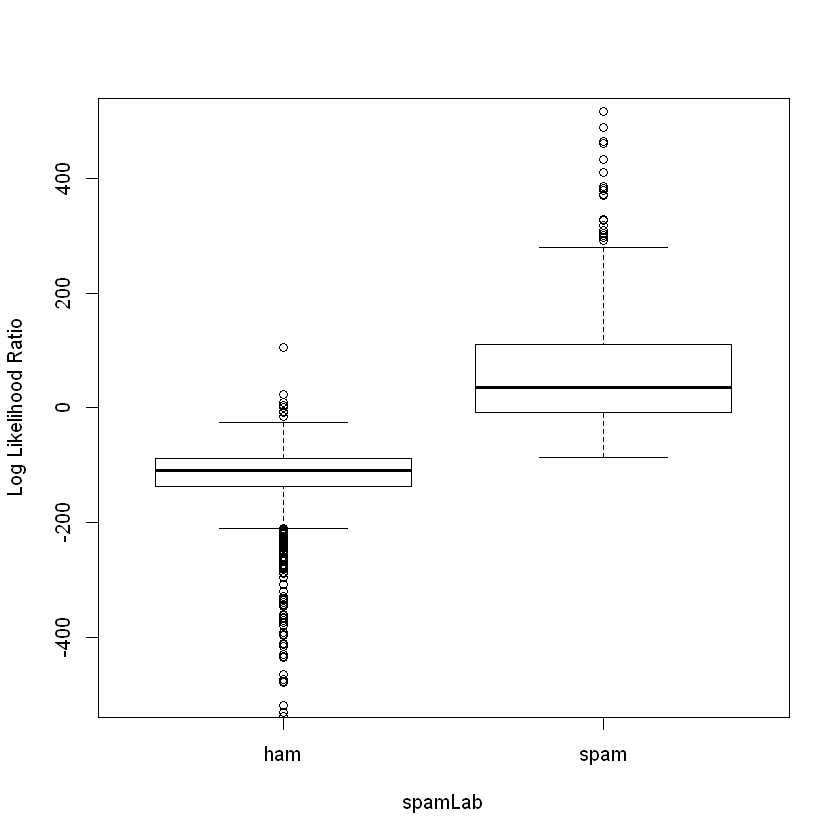

In [19]:
#pdf("SP_Boxplot.pdf", width = 6, height = 6)
spamLab = c("ham", "spam")[1 + testIsSpam]
boxplot(testLLR ~ spamLab, ylab = "Log Likelihood Ratio",
      #  main = "Log Likelihood Ratio for Randomly Chosen Test Messages",
        ylim=c(-500, 500))
#dev.off()

In [20]:
typeIErrorRate = 
function(tau, llrVals, spam)
{
  classify = llrVals > tau
  sum(classify & !spam)/sum(!spam)
}

typeIErrorRate(0, testLLR,testIsSpam)

typeIErrorRate(-20, testLLR,testIsSpam)

typeIErrorRates = 
function(llrVals, isSpam) 
{
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]

  idx = which(!isSpam)
  N = length(idx)
  list(error = (N:1)/N, values = llrVals[idx])
}

[1] 0.003884333

[1] 0.006042296

In [21]:
typeIIErrorRates = function(llrVals, isSpam) {
    
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]
    
    
  idx = which(isSpam)
  N = length(idx)
  list(error = (1:(N))/N, values = llrVals[idx])
  }  

xI = typeIErrorRates(testLLR, testIsSpam)
xII = typeIIErrorRates(testLLR, testIsSpam)
tau01 = round(min(xI$values[xI$error <= 0.01]))
t2 = max(xII$error[ xII$values < tau01 ])

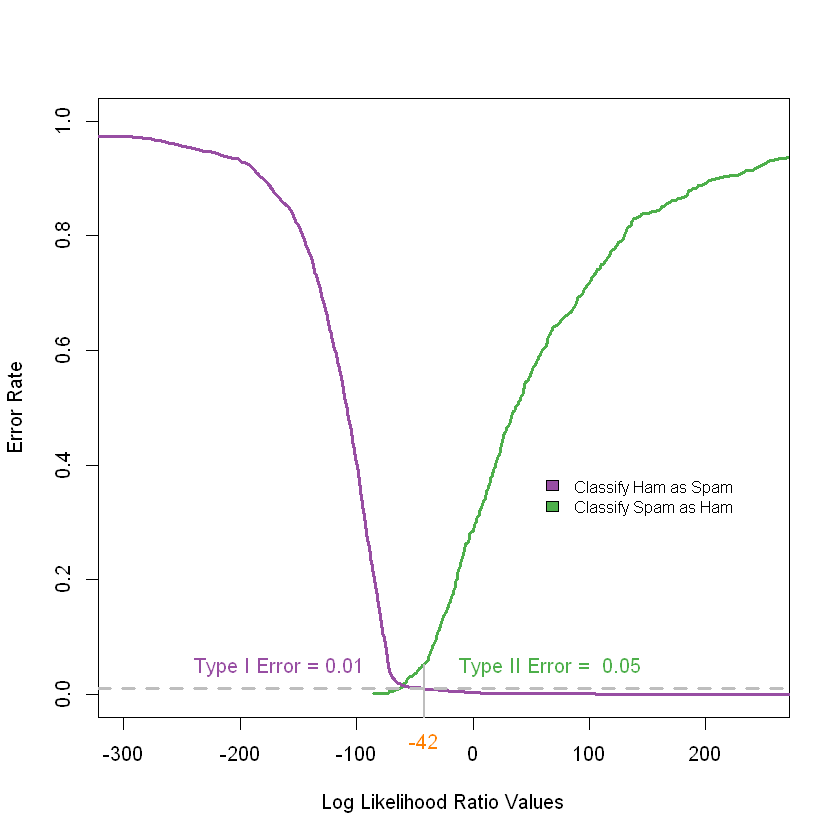

In [22]:
#pdf("LinePlotTypeI+IIErrors.pdf", width = 8, height = 6)

library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(xII$error ~ xII$values,  type = "l", col = cols[1], lwd = 3,
     xlim = c(-300, 250), ylim = c(0, 1),
     xlab = "Log Likelihood Ratio Values", ylab="Error Rate")
points(xI$error ~ xI$values, type = "l", col = cols[2], lwd = 3)
legend(x = 50, y = 0.4, fill = c(cols[2], cols[1]),
       legend = c("Classify Ham as Spam", 
                  "Classify Spam as Ham"), cex = 0.8,
       bty = "n")
abline(h=0.01, col ="grey", lwd = 3, lty = 2)
text(-250, 0.05, pos = 4, "Type I Error = 0.01", col = cols[2])

mtext(tau01, side = 1, line = 0.5, at = tau01, col = cols[3])
segments(x0 = tau01, y0 = -.50, x1 = tau01, y1 = t2, 
         lwd = 2, col = "grey")
text(tau01 + 20, 0.05, pos = 4,
     paste("Type II Error = ", round(t2, digits = 2)), 
     col = cols[1])

#dev.off()

In [23]:
k = 5
numTrain = length(trainMsgWords)
partK = sample(numTrain)
tot = k * floor(numTrain/k)
partK = matrix(partK[1:tot], ncol = k)

testFoldOdds = NULL
for (i in 1:k) {
  foldIdx = partK[ , i]
  trainTabFold = computeFreqs(trainMsgWords[-foldIdx], trainIsSpam[-foldIdx])
  testFoldOdds = c(testFoldOdds, 
               sapply(trainMsgWords[ foldIdx ], computeMsgLLR, trainTabFold))
}

testFoldSpam = NULL
for (i in 1:k) {
  foldIdx = partK[ , i]
  testFoldSpam = c(testFoldSpam, trainIsSpam[foldIdx])
}

xFoldI = typeIErrorRates(testFoldOdds, testFoldSpam)
xFoldII = typeIIErrorRates(testFoldOdds, testFoldSpam)
tauFoldI = round(min(xFoldI$values[xFoldI$error <= 0.01]))
tFold2 = xFoldII$error[ xFoldII$values < tauFoldI ]

smallNums = rep((1/2)^40, 2000000)

In [24]:
largeNum = 10000

print(sum(smallNums), digits = 20)

print(largeNum + sum(smallNums), digits = 20)

for (i in 1:length(smallNums)) {
  largeNum = largeNum + smallNums[i]
}
print(largeNum, digits = 20)

sampleSplit = lapply(sampleEmail, splitMessage)

header = sampleSplit[[1]]$header
header[1:12]

header[1] = sub("^From", "Top-From:", header[1])
header[1]

[1] 1.8189894035458565e-06
[1] 10000.000001818989
[1] 10000


[1] "From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002"                                      
 [2] "Return-Path: <exmh-workers-admin@spamassassin.taint.org>"                                          
 [3] "Delivered-To: zzzz@localhost.netnoteinc.com"                                                       
 [4] "Received: from localhost (localhost [127.0.0.1])"                                                  
 [5] "\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36"                                 
 [6] "\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)"                                      
 [7] "Received: from phobos [127.0.0.1]"                                                                 
 [8] "\tby localhost with IMAP (fetchmail-5.9.0)"                                                         
 [9] "\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)"                          
[10] "Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by"
[11] "    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for"                            
[12] "    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100"

[1] "Top-From: exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002"

In [25]:
headerPieces = read.dcf(textConnection(header), all = TRUE)

headerPieces[, "Delivered-To"]


headerVec = unlist(headerPieces)
dupKeys = sapply(headerPieces, function(x) length(unlist(x)))
names(headerVec) = rep(colnames(headerPieces), dupKeys)

headerVec[ which(names(headerVec) == "Delivered-To") ]

length(headerVec)

length(unique(names(headerVec)))

processHeader = function(header)
{
       # modify the first line to create a key:value pair
  header[1] = sub("^From", "Top-From:", header[1])
  
  headerMat = read.dcf(textConnection(header), all = TRUE)
  headerVec = unlist(headerMat)
  
  dupKeys = sapply(headerMat, function(x) length(unlist(x)))
  names(headerVec) = rep(colnames(headerMat), dupKeys)
  
  return(headerVec)
}

[[1]]
[1] "zzzz@localhost.netnoteinc.com"              
[2] "exmh-workers@listman.spamassassin.taint.org"

Delivered-To 
              "zzzz@localhost.netnoteinc.com" 
                                 Delivered-To 
"exmh-workers@listman.spamassassin.taint.org"

[1] 36

[1] 26

In [26]:
headerList = lapply(sampleSplit, 
                    function(msg) {
                      processHeader(msg$header)} )

contentTypes = sapply(headerList, function(header) 
                                        header["Content-Type"])
names(contentTypes) = NULL
contentTypes

hasAttach = grep("^ *multi", tolower(contentTypes))
hasAttach

boundaries = getBoundary(contentTypes[ hasAttach ])
boundaries

boundary = boundaries[9]
body = sampleSplit[[15]]$body

bString = paste("--", boundary, sep = "")
bStringLocs = which(bString == body)
bStringLocs

eString = paste("--", boundary, "--", sep = "")
eStringLoc = which(eString == body)
eStringLoc

diff(c(bStringLocs[-1], eStringLoc))

[1] "text/plain; charset=us-ascii"                                                                                   
 [2] "text/plain; charset=US-ASCII"                                                                                   
 [3] "text/plain; charset=US-ASCII"                                                                                   
 [4] "text/plain; charset=\"us-ascii\""                                                                               
 [5] "text/plain; charset=US-ASCII"                                                                                   
 [6] "multipart/signed;\nboundary=\"==_Exmh_-1317289252P\";\nmicalg=pgp-sha1;\nprotocol=\"application/pgp-signature\""
 [7] NA                                                                                                               
 [8] "multipart/alternative;\nboundary=\"----=_NextPart_000_00C1_01C25017.F2F04E20\""                                 
 [9] "multipart/alternative; boundary=Apple-Mail-2-874629474"                                                         
[10] "multipart/signed;\nboundary=\"==_Exmh_-518574644P\";\nmicalg=pgp-sha1;\nprotocol=\"application/pgp-signature\"" 
[11] "multipart/related;\nboundary=\"------------090602010909000705010009\""                                          
[12] "multipart/signed;\nboundary=\"==_Exmh_-451422450P\";\nmicalg=pgp-sha1;\nprotocol=\"application/pgp-signature\"" 
[13] "multipart/signed;\nboundary=\"==_Exmh_267413022P\";\nmicalg=pgp-sha1;\nprotocol=\"application/pgp-signature\""  
[14] "multipart/mixed;\nboundary=\"----=_NextPart_000_0005_01C26412.7545C1D0\""                                       
[15] "multipart/alternative;\nboundary=\"------------080209060700030309080805\""

[1]  6  8  9 10 11 12 13 14 15

[1] "==_Exmh_-1317289252P"                     
[2] "----=_NextPart_000_00C1_01C25017.F2F04E20"
[3] "Apple-Mail-2-874629474"                   
[4] "==_Exmh_-518574644P"                      
[5] "------------090602010909000705010009"     
[6] "==_Exmh_-451422450P"                      
[7] "==_Exmh_267413022P"                       
[8] "----=_NextPart_000_0005_01C26412.7545C1D0"
[9] "------------080209060700030309080805"

[1]  2 35

[1] 77

[1] 42

In [27]:
### This code has mistakes in it - and we fix them later!
processAttach = function(body, contentType){
  
  boundary = getBoundary(contentType)
  
  bString = paste("--", boundary, "$", sep = "")
  bStringLocs = grep(bString, body)
  
  eString = paste("--", boundary, "--$", sep = "")
  eStringLoc = grep(eString, body)
  
  n = length(body)
  
  if (length(eStringLoc) == 0) eStringLoc = n + 1
  if (length(bStringLocs) == 1) attachLocs = NULL
  else attachLocs = c(bStringLocs[-1],  eStringLoc)
  
  msg = body[ (bStringLocs[1] + 1) : min(n, (bStringLocs[2] - 1), 
                                         na.rm = TRUE)]
  
  if ( eStringLoc < n )
    msg = c(msg, body[ (eStringLoc + 1) : n ])
  
  if ( !is.null(attachLocs) ) {
    attachLens = diff(attachLocs, lag = 1) 
    attachTypes = mapply(function(begL, endL) {
      contentTypeLoc = grep("[Cc]ontent-[Tt]ype", body[ (begL + 1) : (endL - 1)])
      contentType = body[ begL + contentTypeLoc]
      contentType = gsub('"', "", contentType )
      MIMEType = sub(" *Content-Type: *([^;]*);?.*", "\\1", contentType)
      return(MIMEType)
    }, attachLocs[-length(attachLocs)], attachLocs[-1])
  }
  
  if (is.null(attachLocs)) return(list(body = msg, attachInfo = NULL) )
  else return(list(body = msg, 
                   attachDF = data.frame(aLen = attachLens, 
                                         aType = attachTypes,
                                         stringsAsFactors = FALSE)))                                
}

In [28]:
bodyList = lapply(sampleSplit, function(msg) msg$body)
attList = mapply(processAttach, bodyList[hasAttach], 
                 contentTypes[hasAttach], 
                 SIMPLIFY = FALSE)

lens = sapply(attList, function(processedA) 
                           processedA$attachDF$aLen)
head(lens)  # will cause an error with the first message. its ok.
attList[[2]]$attachDF

body = bodyList[hasAttach][[2]]
length(body)

body[35:45]

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00014.cb20e10b2bfcb8210a1c310798532a57`
[1] 12

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00062.009f5a1a8fa88f0b38299ad01562bb37`
[1] 44 44

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00063.0acbc484a73f0e0b727e06c100d8df7b`
[1] 83

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/0030.77828e31de08ebb58b583688b87524cc`
[1] 12

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00368.f86324a03e7ae7070cc40f302385f5d3`
NULL

$`C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham/00389.8606961eaeef7b921ce1c53773248d69`
[1] 12

aLen,aType
44,text/html
44,<META http-equiv=3DContent-Type content=3Dtext/html; =


[1] 86

[1] ""                                                                
 [2] "------=_NextPart_000_00C1_01C25017.F2F04E20"                     
 [3] "Content-Type: text/html;"                                        
 [4] "\tcharset=\"Windows-1252\""                                       
 [5] "Content-Transfer-Encoding: quoted-printable"                     
 [6] ""                                                                
 [7] "<!DOCTYPE HTML PUBLIC \"-//W3C//DTD HTML 4.0 Transitional//EN\">"
 [8] "<HTML><HEAD>"                                                    
 [9] "<META http-equiv=3DContent-Type content=3D\"text/html; ="        
[10] "charset=3Dwindows-1252\">"                                       
[11] "<META content=3D\"MSHTML 6.00.2716.2200\" name=3DGENERATOR>"

In [29]:
processAttach = function(body, contentType){

  n = length(body)
  boundary = getBoundary(contentType)
 
  bString = paste("--", boundary, sep = "")
  bStringLocs = which(bString == body)
  eString = paste("--", boundary, "--", sep = "")
  eStringLoc = which(eString == body)
  
  if (length(eStringLoc) == 0) eStringLoc = n
  if (length(bStringLocs) <= 1) {
    attachLocs = NULL
    msgLastLine = n
    if (length(bStringLocs) == 0) bStringLocs = 0
  } else {
    attachLocs = c(bStringLocs[ -1 ],  eStringLoc)
    msgLastLine = bStringLocs[2] - 1
  }
  
  msg = body[ (bStringLocs[1] + 1) : msgLastLine] 
  if ( eStringLoc < n )
    msg = c(msg, body[ (eStringLoc + 1) : n ])
  
  if ( !is.null(attachLocs) ) {
    attachLens = diff(attachLocs, lag = 1) 
    attachTypes = mapply(function(begL, endL) {
      CTloc = grep("^[Cc]ontent-[Tt]ype", body[ (begL + 1) : (endL - 1)])
      if ( length(CTloc) == 0 ) {
        MIMEType = NA
      } else {
        CTval = body[ begL + CTloc[1] ]
        CTval = gsub('"', "", CTval )
        MIMEType = sub(" *[Cc]ontent-[Tt]ype: *([^;]*);?.*", "\\1", CTval)   
      }
      return(MIMEType)
    }, attachLocs[-length(attachLocs)], attachLocs[-1])
  }
  
  if (is.null(attachLocs)) return(list(body = msg, attachDF = NULL) )
  return(list(body = msg, 
             attachDF = data.frame(aLen = attachLens, 
                                     aType = unlist(attachTypes),
                                     stringsAsFactors = FALSE)))                                
}                       

readEmail = function(dirName) {
       # retrieve the names of files in directory
  fileNames = list.files(dirName, full.names = TRUE)
       # drop files that are not email
  notEmail = grep("cmds$", fileNames)
  if ( length(notEmail) > 0) fileNames = fileNames[ - notEmail ]

       # read all files in the directory
  lapply(fileNames, readLines, encoding = "latin1")
}

In [30]:
processAllEmail = function(dirName, isSpam = FALSE)
{
       # read all files in the directory
  messages = readEmail(dirName)
  fileNames = names(messages)
  n = length(messages)
  
       # split header from body
  eSplit = lapply(messages, splitMessage)
  rm(messages)

       # process header as named character vector
  headerList = lapply(eSplit, function(msg) 
                                 processHeader(msg$header))
  
       # extract content-type key
  contentTypes = sapply(headerList, function(header) 
                                       header["Content-Type"])
  
       # extract the body
  bodyList = lapply(eSplit, function(msg) msg$body)
  rm(eSplit)

       # which email have attachments
  hasAttach = grep("^ *multi", tolower(contentTypes))

       # get summary stats for attachments and the shorter body
  attList = mapply(processAttach, bodyList[hasAttach], 
                   contentTypes[hasAttach], SIMPLIFY = FALSE)
  
  bodyList[hasAttach] = lapply(attList, function(attEl) 
                                           attEl$body)
 
  attachInfo = vector("list", length = n )
  attachInfo[ hasAttach ] = lapply(attList, 
                                  function(attEl) attEl$attachDF)
 
       # prepare return structure
  emailList = mapply(function(header, body, attach, isSpam) {
                       list(isSpam = isSpam, header = header, 
                            body = body, attach = attach)
                     },
                     headerList, bodyList, attachInfo, 
                     rep(isSpam, n), SIMPLIFY = FALSE )
  names(emailList) = fileNames
  
  invisible(emailList)
}

In [31]:
emailStruct = mapply(processAllEmail, fullDirNames,
                     isSpam = rep( c(FALSE, TRUE), 3:2))      
emailStruct = unlist(emailStruct, recursive = FALSE)

sampleStruct = emailStruct[ indx ]

save(emailStruct, file="emailXX.rda")

header = sampleStruct[[1]]$header
subject = header["Subject"]
els = strsplit(subject, "")
all(els %in% LETTERS)

testSubject = c("DEAR MADAME", "WINNER!", "")

els = strsplit(testSubject, "")
sapply(els, function(subject) all(subject %in% LETTERS))


gsub("[[:punct:] ]", "", testSubject)

gsub("[^[:alpha:]]", "", testSubject)

Warning message in FUN(X[[i]], ...):
"incomplete final line found on 'C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/hard_ham/00228.0eaef7857bbbf3ebf5edbbdae2b30493'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on 'C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/hard_ham/0231.7c6cc716ce3f3bfad7130dd3c8d7b072'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on 'C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/hard_ham/0250.7c6cc716ce3f3bfad7130dd3c8d7b072'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on 'C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/spam/00136.faa39d8e816c70f23b4bb8758d8a74f0'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on 'C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/spam/0143.260a940290dcb61f9327b224a368d4af'"

[1] FALSE

[1] FALSE FALSE  TRUE

[1] "DEARMADAME" "WINNER"     ""

[1] "DEARMADAME" "WINNER"     ""

In [32]:
isYelling = function(msg) {
  if ( "Subject" %in% names(msg$header) ) {
     el = gsub("[^[:alpha:]]", "", msg$header["Subject"])
     if (nchar(el) > 0) 
        nchar(gsub("[A-Z]", "", el)) < 1
     else 
        FALSE
  } else 
    NA
}

perCaps =
function(msg)
{
  body = paste(msg$body, collapse = "")

       # Return NA if the body of the message is "empty"
  if(length(body) == 0 || nchar(body) == 0) return(NA)

       # Eliminate non-alpha characters
  body = gsub("[^[:alpha:]]", "", body)
  capText = gsub("[^A-Z]", "", body)
  100 * nchar(capText)/nchar(body)
}

In [33]:
sapply(sampleStruct, perCaps)

funcList = list( 
 isRe = function(msg) {
       "Subject" %in% names(msg$header) &&
         length(grep("^[ \t]*Re:", msg$header[["Subject"]])) > 0
  },
  numLines = function(msg) 
                length(msg$body),
  isYelling = function(msg) {
    if ( "Subject" %in% names(msg$header) ) {
       el = gsub("[^[:alpha:]]", "", msg$header["Subject"])
       if (nchar(el) > 0) 
         nchar(gsub("[A-Z]", "", el)) < 1
       else 
         FALSE
    }
    else NA
  },
  perCaps = function(msg) {
    body = paste(msg$body, collapse = "")

         # Return NA if the body of the message is "empty"
    if(length(body) == 0 || nchar(body) == 0) return(NA)

         # Eliminate non-alpha characters
    body = gsub("[^[:alpha:]]", "", body)
    capText = gsub("[^A-Z]", "", body)
    100 * nchar(capText)/nchar(body)
  }
)

C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham1 
                                                                      4.451039 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham2 
                                                                      7.491289 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham3 
                                                                      7.436096 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham4 
                                                                      5.090909 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham5 
                                                                      6.116643 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham15 
                                                                      7.732865 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham27 
                                                                      5.523256 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham68 
                                                                     10.059172 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham69 
                                                                     10.885806 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham329 
                                                                      6.472492 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham404 
                                                                      9.597258 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham427 
                                                                     11.970075 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham516 
                                                                      9.233792 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham852 
                                                                      1.655629 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham971 
                                                                      6.417910

In [34]:
lapply(funcList, function(func) 
                   sapply(sampleStruct, function(msg) func(msg)))

createDerivedDF =
function(email = emailStruct, operations = funcList, 
         verbose = FALSE)
{
  els = lapply(names(operations),
               function(id) {
                 if(verbose) print(id)
                 e = operations[[id]]
                 v = if(is.function(e)) 
                        sapply(email, e)
                      else 
                        sapply(email, function(msg) eval(e))
                 v
         })

   df = as.data.frame(els)
   names(df) = names(operations)
   invisible(df)
}

sampleDF = createDerivedDF(sampleStruct)
head(sampleDF)

$isRe
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham1 
                                                                          TRUE 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham2 
                                                                         FALSE 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham3 
                                                                         FALSE 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham4 
                                                                         FALSE 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham5 
                                                                          TRUE 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham15 
                                                                          TRUE 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham27 
                                                                          TRUE 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham68 
                                                                         FALSE 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham69 
                                                                          TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham329 
                                                                          TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham404 
                                                                          TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham427 
                                                                          TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham516 
                                                                          TRUE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham852 
                                                                         FALSE 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham971 
                                                                          TRUE 

$numLines
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham1 
                                                                            50 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham2 
                                                                            26 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham3 
                                                                            38 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham4 
                                                                            32 
  C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham5 
                                                                            31 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham15 
                                                                            54 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham27 
                                                                            35 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham68 
                                                                            36 
 C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham69 
                                                                            65 
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham329 
                                                               

,isRe,numLines,isYelling,perCaps
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham1,TRUE,50,FALSE,4.451039
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham2,FALSE,26,FALSE,7.491289
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham3,FALSE,38,FALSE,7.436096
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham4,FALSE,32,FALSE,5.090909
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham5,TRUE,31,FALSE,6.116643
C:/Users/WilliamNayden/Documents/MSDS/20050311_spam_2.tar/messages/easy_ham15,TRUE,54,FALSE,7.732865


In [35]:
funcList = list(
  isSpam =
    expression(msg$isSpam)
  ,
  isRe =
    function(msg) {
      # Can have a Fwd: Re:  ... but we are not looking for this here.
      # We may want to look at In-Reply-To field.
      "Subject" %in% names(msg$header) && 
        length(grep("^[ \t]*Re:", msg$header[["Subject"]])) > 0
    }
  ,
  numLines =
    function(msg) length(msg$body)
  ,
  bodyCharCt =
    function(msg)
      sum(nchar(msg$body))
  ,
  underscore =
    function(msg) {
      if(!"Reply-To" %in% names(msg$header))
        return(FALSE)
      
      txt <- msg$header[["Reply-To"]]
      length(grep("_", txt)) > 0  && 
        length(grep("[0-9A-Za-z]+", txt)) > 0
    }
  ,
  subExcCt = 
    function(msg) {
      x = msg$header["Subject"]
      if(length(x) == 0 || sum(nchar(x)) == 0 || is.na(x))
        return(NA)
      
      sum(nchar(gsub("[^!]","", x)))
    }
  ,
  subQuesCt =
    function(msg) {
      x = msg$header["Subject"]
      if(length(x) == 0 || sum(nchar(x)) == 0 || is.na(x))
        return(NA)
      
      sum(nchar(gsub("[^?]","", x)))
    }
  ,
  numAtt = 
    function(msg) {
      if (is.null(msg$attach)) return(0)
      else nrow(msg$attach)
    }
   
  ,
  priority =
    function(msg) {
      ans <- FALSE
      # Look for names X-Priority, Priority, X-Msmail-Priority
      # Look for high any where in the value
      ind = grep("priority", tolower(names(msg$header)))
      if (length(ind) > 0)  {
        ans <- length(grep("high", tolower(msg$header[ind]))) >0
      }
      ans
    }
  ,
  numRec =
    function(msg) {
      # unique or not.
      els = getMessageRecipients(msg$header)
      
      if(length(els) == 0)
        return(NA)
      
      # Split each line by ","  and in each of these elements, look for
      # the @ sign. This handles
      tmp = sapply(strsplit(els, ","), function(x) grep("@", x))
      sum(sapply(tmp, length))
    }
  ,
  perCaps =
    function(msg)
    {
      body = paste(msg$body, collapse = "")
      
      # Return NA if the body of the message is "empty"
      if(length(body) == 0 || nchar(body) == 0) return(NA)
      
      # Eliminate non-alpha characters and empty lines 
      body = gsub("[^[:alpha:]]", "", body)
      els = unlist(strsplit(body, ""))
      ctCap = sum(els %in% LETTERS)
      100 * ctCap / length(els)
    }
  ,
  isInReplyTo =
    function(msg)
    {
      "In-Reply-To" %in% names(msg$header)
    }
  ,
  sortedRec =
    function(msg)
    {
      ids = getMessageRecipients(msg$header)
      all(sort(ids) == ids)
    }
  ,
  subPunc =
    function(msg)
    {
      if("Subject" %in% names(msg$header)) {
        el = gsub("['/.:@-]", "", msg$header["Subject"])
        length(grep("[A-Za-z][[:punct:]]+[A-Za-z]", el)) > 0
      }
      else
        FALSE
    },
  hour =
    function(msg)
    {
      date = msg$header["Date"]
      if ( is.null(date) ) return(NA)
      # Need to handle that there may be only one digit in the hour
      locate = regexpr("[0-2]?[0-9]:[0-5][0-9]:[0-5][0-9]", date)
      
      if (locate < 0)
        locate = regexpr("[0-2]?[0-9]:[0-5][0-9]", date)
      if (locate < 0) return(NA)
      
      hour = substring(date, locate, locate+1)
      hour = as.numeric(gsub(":", "", hour))
      
      locate = regexpr("PM", date)
      if (locate > 0) hour = hour + 12
      
      locate = regexpr("[+-][0-2][0-9]00", date)
      if (locate < 0) offset = 0
      else offset = as.numeric(substring(date, locate, locate + 2))
      (hour - offset) %% 24
    }
  ,
  multipartText =
    function(msg)
    {
      if (is.null(msg$attach)) return(FALSE)
      numAtt = nrow(msg$attach)
      
      types = 
        length(grep("(html|plain|text)", msg$attach$aType)) > (numAtt/2)
    }
  ,
  hasImages =
    function(msg)
    {
      if (is.null(msg$attach)) return(FALSE)
      
      length(grep("^ *image", tolower(msg$attach$aType))) > 0
    }
  ,
  isPGPsigned =
    function(msg)
    {
      if (is.null(msg$attach)) return(FALSE)
      
      length(grep("pgp", tolower(msg$attach$aType))) > 0
    },
  perHTML =
    function(msg)
    {
      if(! ("Content-Type" %in% names(msg$header))) return(0)
      
      el = tolower(msg$header["Content-Type"]) 
      if (length(grep("html", el)) == 0) return(0)
      
      els = gsub("[[:space:]]", "", msg$body)
      totchar = sum(nchar(els))
      totplain = sum(nchar(gsub("<[^<]+>", "", els )))
      100 * (totchar - totplain)/totchar
    },
  subSpamWords =
    function(msg)
    {
      if("Subject" %in% names(msg$header))
        length(grep(paste(SpamCheckWords, collapse = "|"), 
                    tolower(msg$header["Subject"]))) > 0
      else
        NA
    }
  ,
  subBlanks =
    function(msg)
    {
      if("Subject" %in% names(msg$header)) {
        x = msg$header["Subject"]
        # should we count blank subject line as 0 or 1 or NA?
        if (nchar(x) == 1) return(0)
        else 100 *(1 - (nchar(gsub("[[:blank:]]", "", x))/nchar(x)))
      } else NA
    }
  ,
  noHost =
    function(msg)
    {
      # Or use partial matching.
      idx = pmatch("Message-", names(msg$header))
      
      if(is.na(idx)) return(NA)
      
      tmp = msg$header[idx]
      return(length(grep(".*@[^[:space:]]+", tmp)) ==  0)
    }
  ,
  numEnd =
    function(msg)
    {
      # If we just do a grep("[0-9]@",  )
      # we get matches on messages that have a From something like
      # " \"marty66@aol.com\" <synjan@ecis.com>"
      # and the marty66 is the "user's name" not the login
      # So we can be more precise if we want.
      x = names(msg$header)
      if ( !( "From" %in% x) ) return(NA)
      login = gsub("^.*<", "", msg$header["From"])
      if ( is.null(login) ) 
        login = gsub("^.*<", "", msg$header["X-From"])
      if ( is.null(login) ) return(NA)
      login = strsplit(login, "@")[[1]][1]
      length(grep("[0-9]+$", login)) > 0
    },
  isYelling =
    function(msg)
    {
      if ( "Subject" %in% names(msg$header) ) {
        el = gsub("[^[:alpha:]]", "", msg$header["Subject"])
        if (nchar(el) > 0) nchar(gsub("[A-Z]", "", el)) < 1
        else FALSE
      }
      else
        NA
    },
  forwards =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0 || sum(nchar(x)) == 0)
        return(NA)
      
      ans = length(grep("^[[:space:]]*>", x))
      100 * ans / length(x)
    },
  isOrigMsg =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0) return(NA)
      
      length(grep("^[^[:alpha:]]*original[^[:alpha:]]+message[^[:alpha:]]*$", 
                  tolower(x) ) ) > 0
    },
  isDear =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0) return(NA)
      
      length(grep("^[[:blank:]]*dear +(sir|madam)\\>", 
                  tolower(x))) > 0
    },
  isWrote =
    function(msg)
    {
      x = msg$body
      if(length(x) == 0) return(NA)
      
      length(grep("(wrote|schrieb|ecrit|escribe):", tolower(x) )) > 0
    },
  avgWordLen =
    function(msg)
    {
      txt = paste(msg$body, collapse = " ")
      if(length(txt) == 0 || sum(nchar(txt)) == 0) return(0)
      
      txt = gsub("[^[:alpha:]]", " ", txt)
      words = unlist(strsplit(txt, "[[:blank:]]+"))
      wordLens = nchar(words)
      mean(wordLens[ wordLens > 0 ])
    }
  ,
  numDlr =
    function(msg)
    {
      x = paste(msg$body, collapse = "")
      if(length(x) == 0 || sum(nchar(x)) == 0)
        return(NA)
      
      nchar(gsub("[^$]","", x))
    }
)

In [36]:
SpamCheckWords =
  c("viagra", "pounds", "free", "weight", "guarantee", "million", 
    "dollars", "credit", "risk", "prescription", "generic", "drug",
    "financial", "save", "dollar", "erotic", "million", "barrister",
    "beneficiary", "easy", 
    "money back", "money", "credit card")


getMessageRecipients =
  function(header)
  {
    c(if("To" %in% names(header))  header[["To"]] else character(0),
      if("Cc" %in% names(header))  header[["Cc"]] else character(0),
      if("Bcc" %in% names(header)) header[["Bcc"]] else character(0)
    )
  }

emailDF = createDerivedDF(emailStruct)
dim(emailDF)
#save(emailDF, file = "spamAssassinDerivedDF.rda")

[1] 9348   30

In [37]:
#load("Data/spamAssassinDerivedDF.rda")
dim(emailDF)

perCaps2 =
function(msg)
{
  body = paste(msg$body, collapse = "")

       # Return NA if the body of the message is "empty"
  if(length(body) == 0 || nchar(body) == 0) return(NA)

       # Eliminate non-alpha characters and empty lines 
  body = gsub("[^[:alpha:]]", "", body)
  els = unlist(strsplit(body, ""))
  ctCap = sum(els %in% LETTERS)
  100 * ctCap / length(els)
}

[1] 9348   30

In [38]:
pC = sapply(emailStruct, perCaps)
pC2 = sapply(emailStruct, perCaps2)
identical(pC, pC2)

indNA = which(is.na(emailDF$subExcCt))

indNoSubject = which(sapply(emailStruct, 
                            function(msg) 
                              !("Subject" %in% names(msg$header))))

all(indNA == indNoSubject)

all(emailDF$bodyCharCt > emailDF$numLines)


x.at = c(1,10,100,1000,10000,100000)
y.at = c(1, 5, 10, 50, 100, 500, 5000)
nL = 1 + emailDF$numLines
nC = 1 + emailDF$bodyCharCt

[1] TRUE

Warning message in indNA == indNoSubject:
"longer object length is not a multiple of shorter object length"

[1] FALSE

[1] TRUE

null device 
          1

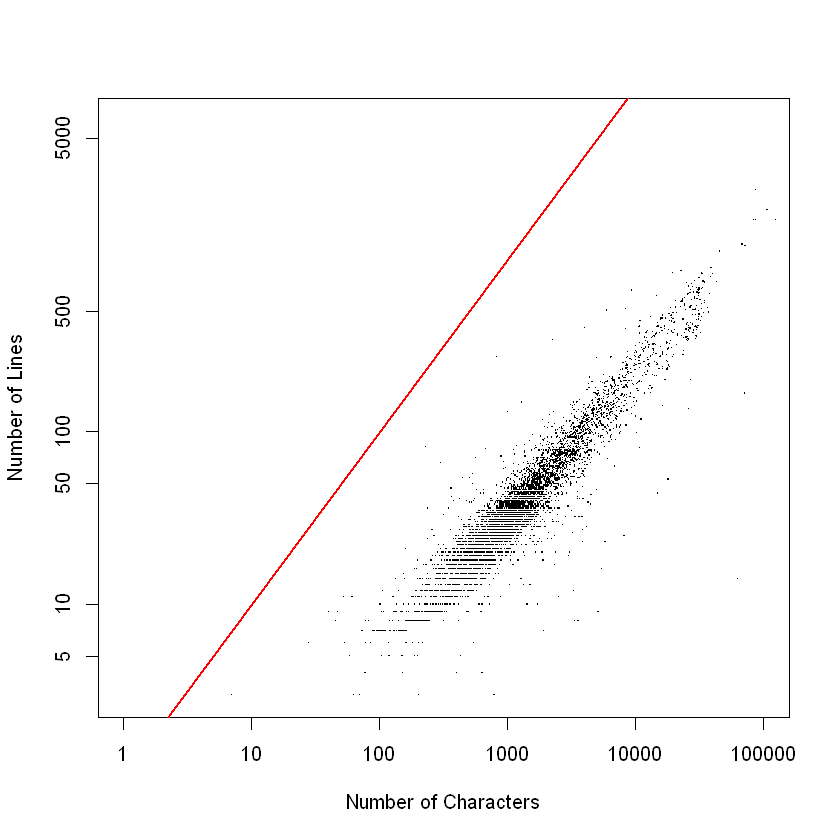

In [39]:
#pdf("ScatterPlotNumLinesNumChars.pdf", width = 6, height = 4.5)
plot(nL ~ nC, log = "xy", pch=".", xlim=c(1,100000), axes = FALSE,
     xlab = "Number of Characters", ylab = "Number of Lines")
box() 
axis(1, at = x.at, labels = formatC(x.at, digits = 0, format="d"))
axis(2, at = y.at, labels = formatC(y.at, digits = 0, format="d")) 
abline(a=0, b=1, col="red", lwd = 2)
dev.off()

#pdf("SPAM_boxplotsPercentCaps.pdf", width = 5, height = 5)

percent = emailDF$perCaps
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "Percent Capitals (log)")

#dev.off()

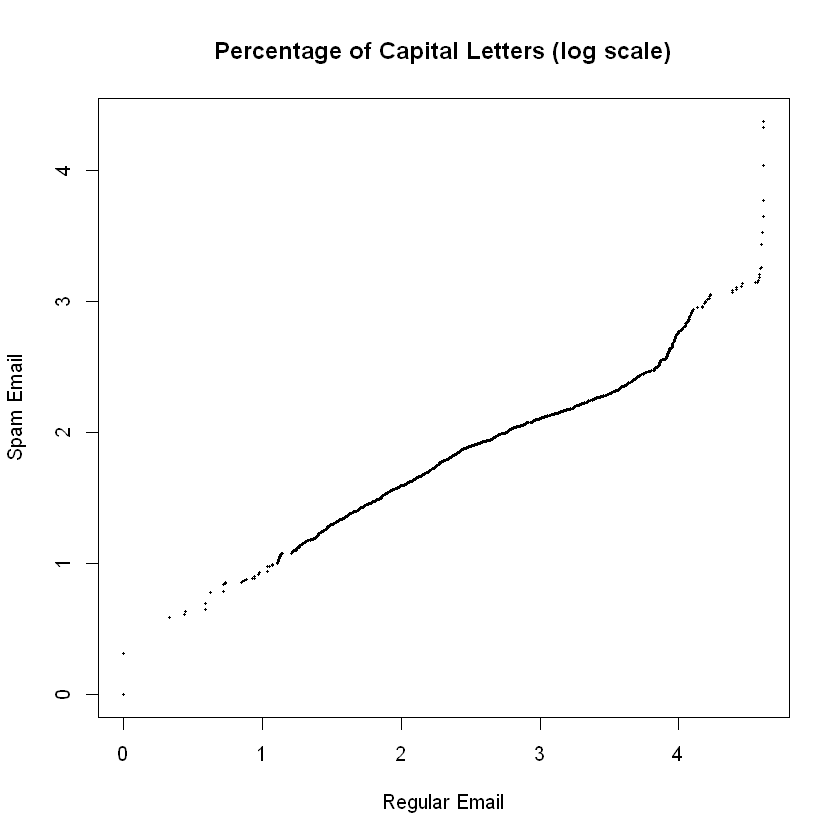

In [40]:
logPerCapsSpam = log(1 + emailDF$perCaps[ emailDF$isSpam ])
logPerCapsHam = log(1 + emailDF$perCaps[ !emailDF$isSpam ])

qqplot(logPerCapsSpam, logPerCapsHam, 
       xlab = "Regular Email", ylab = "Spam Email", 
       main = "Percentage of Capital Letters (log scale)",
       pch = 19, cex = 0.3)

    isSpamLabs
      ham spam
  0  6624 2158
  1   314  230
  2    11    6
  4     0    1
  5     1    2
  18    1    0

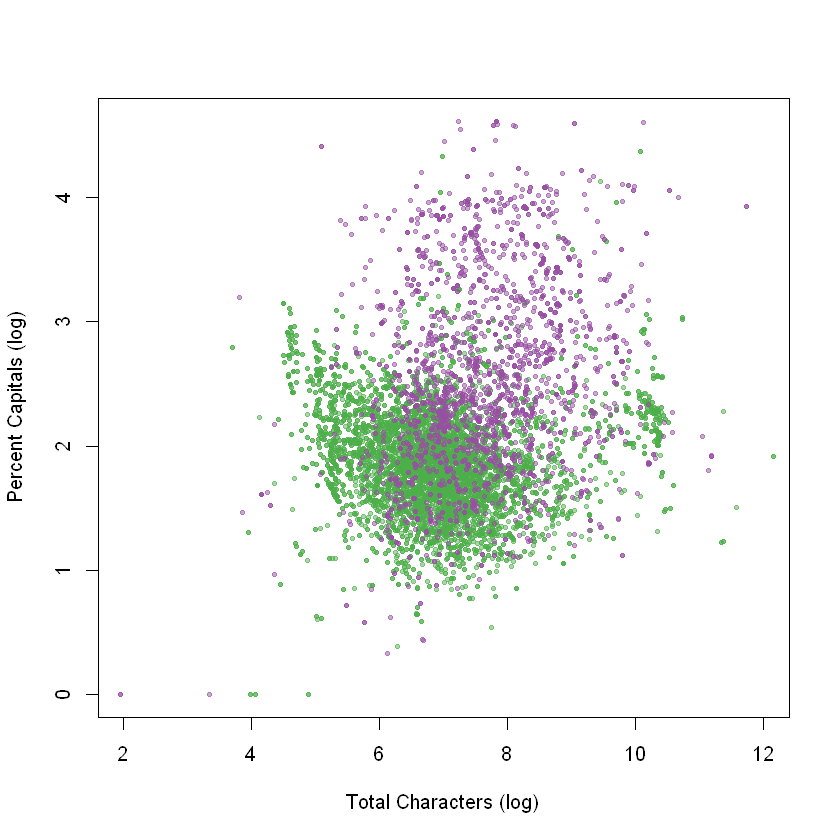

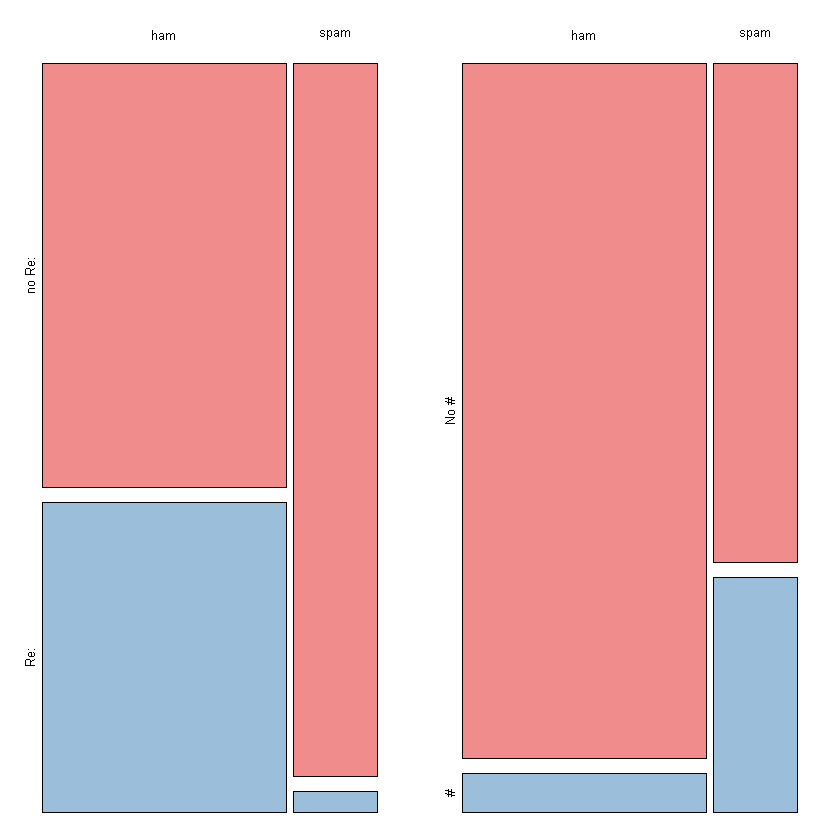

In [41]:
#pdf("SPAM_scatterplotPercentCapsTotChars.pdf", width = 8, height = 6)
 
colI = c("#4DAF4A80", "#984EA380")
logBodyCharCt = log(1 + emailDF$bodyCharCt)
logPerCaps = log(1 + emailDF$perCaps)
plot(logPerCaps ~ logBodyCharCt, xlab = "Total Characters (log)",
     ylab = "Percent Capitals (log)",
     col = colI[1 + emailDF$isSpam],
     xlim = c(2,12), pch = 19, cex = 0.5)

#dev.off()

table(emailDF$numAtt, isSpamLabs)
#pdf("SPAM_mosaicPlots.pdf", width = 8, height = 4)

oldPar = par(mfrow = c(1, 2), mar = c(1,1,1,1))

colM = c("#E41A1C80", "#377EB880")
isRe = factor(emailDF$isRe, labels = c("no Re:", "Re:"))
mosaicplot(table(isSpamLabs, isRe), main = "",
           xlab = "", ylab = "", color = colM)

fromNE = factor(emailDF$numEnd, labels = c("No #", "#"))
mosaicplot(table(isSpamLabs, fromNE), color = colM,
           main = "", xlab="", ylab = "")

par(oldPar)

#dev.off()

library(rpart)

setupRpart = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.factor(x)
                      levels(x) = c("F", "T")
                      x
                   })
  cbind(facVars, data[ , - logicalVars])
}

emailDFrp = setupRpart(emailDF)

In [42]:
set.seed(418910)
testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))

testDF = 
  rbind( emailDFrp[ emailDFrp$isSpam == "T", ][testSpamIdx, ],
         emailDFrp[emailDFrp$isSpam == "F", ][testHamIdx, ] )
trainDF =
  rbind( emailDFrp[emailDFrp$isSpam == "T", ][-testSpamIdx, ], 
         emailDFrp[emailDFrp$isSpam == "F", ][-testHamIdx, ])

rpartFit = rpart(isSpam ~ ., data = trainDF, method = "class")

Warning message:
"package 'rpart.plot' was built under R version 3.6.3"

F    T 
2167  150

[1] 0.06473889

[1] 0.1864831

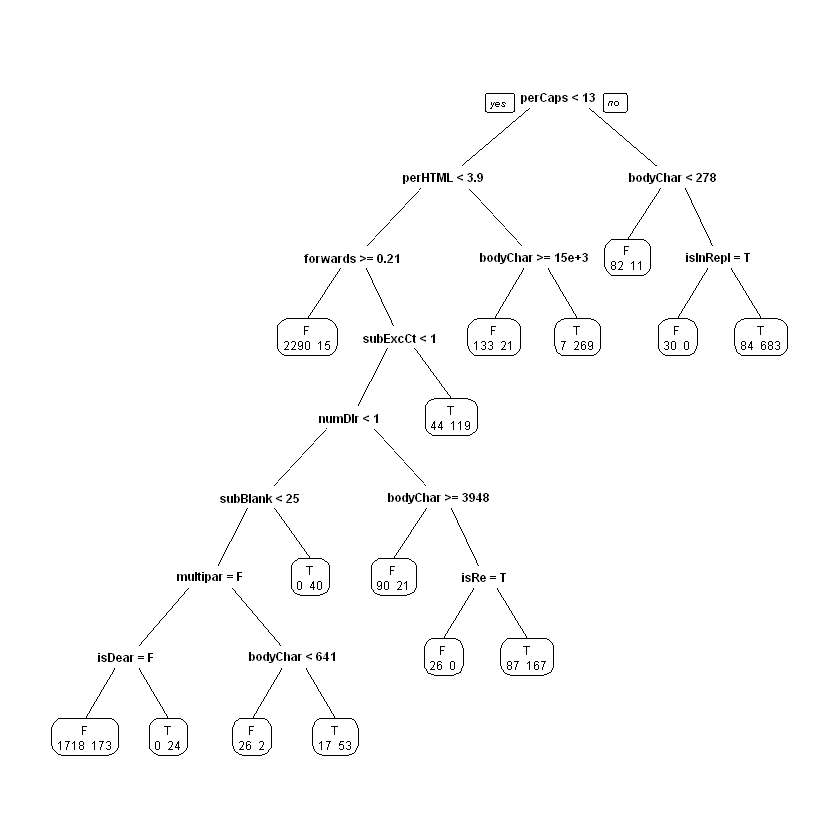

In [43]:
library(rpart.plot)

prp(rpartFit, extra = 1)

library(rpart.plot)
#pdf("SPAM_rpartTree.pdf", width = 7, height = 7)

prp(rpartFit, extra = 1)
#dev.off()

predictions = predict(rpartFit, 
       newdata = testDF[, names(testDF) != "isSpam"],
       type = "class")
 
predsForHam = predictions[ testDF$isSpam == "F" ]
summary(predsForHam)

sum(predsForHam == "T") / length(predsForHam)

predsForSpam = predictions[ testDF$isSpam == "T" ]
sum(predsForSpam == "F") / length(predsForSpam)

complexityVals = c(seq(0.00001, 0.0001, length=19),
                   seq(0.0001, 0.001, length=19), 
                   seq(0.001, 0.005, length=9),
                   seq(0.005, 0.01, length=9))

In [44]:
fits = lapply(complexityVals, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(cp=x) )
           
         predict(rpartObj, 
                 newdata = testDF[ , names(testDF) != "isSpam"],
                 type = "class")
        })

spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
                     })

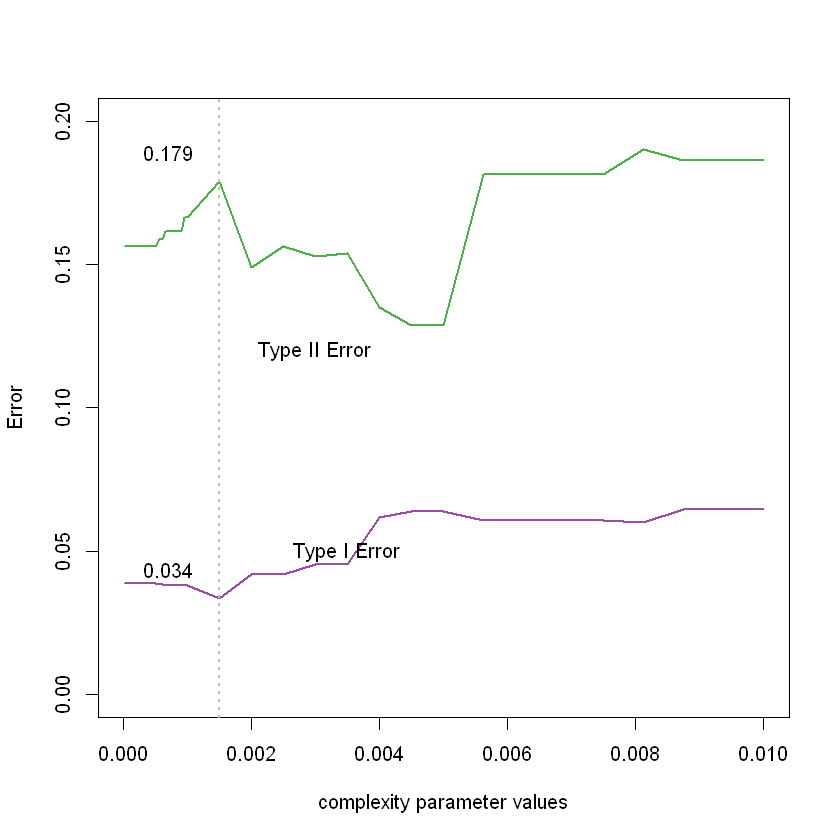

In [45]:
#pdf("SPAM_rpartTypeIandII.pdf", width = 8, height = 7)
library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(errs[1,] ~ complexityVals, type="l", col=cols[2], 
     lwd = 2, ylim = c(0,0.2), xlim = c(0,0.01), 
     ylab="Error", xlab="complexity parameter values")
points(errs[2,] ~ complexityVals, type="l", col=cols[1], lwd = 2)

text(x =c(0.003, 0.0035), y = c(0.12, 0.05), 
     labels=c("Type II Error", "Type I Error"))

minI = which(errs[1,] == min(errs[1,]))[1]
abline(v = complexityVals[minI], col ="grey", lty =3, lwd=2)

text(0.0007, errs[1, minI]+0.01, 
     formatC(errs[1, minI], digits = 2))
text(0.0007, errs[2, minI]+0.01, 
     formatC(errs[2, minI], digits = 3))

#dev.off()

In [46]:
save(emailDFrp,file="data.Rda")

In [47]:
library(caret)

Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate



In [48]:
setupRnum = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.numeric(x)
                   })
  cbind(facVars, data[ , - logicalVars])
}

emailDFnum = setupRnum(emailDF)

emailDFnum[is.na(emailDFnum)]<-0

In [49]:
cv_folds <- createFolds(emailDFnum$isSpam, k=5, list=TRUE, returnTrain = TRUE)
lengths(cv_folds)

Fold1 Fold2 Fold3 Fold4 Fold5 
 7479  7478  7478  7479  7478

In [50]:
library(MLmetrics)
f1 <- function(data, lev = NULL, model = NULL) {
  f1_val <- F1_Score(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  p <- Precision(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  r <- Recall(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  fp <-sum(data$pred==0 & data$obs==1)/length(data$pred)  
 
  fn <-sum(data$pred==1 & data$obs==0)/length(data$pred)
    c(F1 = f1_val,
    prec = p,
    rec = r,
    Type_I_err=fp,
    Type_II_err=fn
   )
}

Warning message:
"package 'MLmetrics' was built under R version 3.6.3"
Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall



In [51]:
library(naivebayes)
library(e1071)
nb_grid<-expand.grid(laplace=c(0,0.1,0.3,0.5,1), usekernel=c(T,F), adjust=c(T,F))
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_nb<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, method='naive_bayes',tuneGrid = nb_grid)
model_nb

Warning message:
"package 'naivebayes' was built under R version 3.6.3"naivebayes 0.9.7 loaded
Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."Warning message:
"model fit failed for Fold1: laplace=0.0, usekernel= TRUE, adjust=FALSE Error in density.default(x, na.rm = TRUE, ...) : 'bw' is not positive.
"Warning message:
"model fit failed for Fold1: laplace=0.1, usekernel= TRUE, adjust=FALSE Error in density.default(x, na.rm = TRUE, ...) : 'bw' is not positive.
"Warning message:
"model fit failed for Fold1: laplace=0.3, usekernel= TRUE, adjust=FALSE Error in density.default(x, na.rm = TRUE, ...) : 'bw' is not positive.
"Warning message:
"model fit failed for Fold1: laplace=0.5, usekernel= TRUE, adjust=FALSE Error in density.default(x, na.rm = TRUE, ...) : 'bw' is not positive.
"Warning message:
"model fit failed for Fold1: laplace=1.0, use

Naive Bayes 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  laplace  usekernel  adjust  F1         prec       rec        Type_I_err
  0.0      FALSE      FALSE   0.9246638  0.9391819  0.9106603  0.04385965
  0.0      FALSE       TRUE   0.9246638  0.9391819  0.9106603  0.04385965
  0.0       TRUE      FALSE         NaN        NaN        NaN         NaN
  0.0       TRUE       TRUE   0.8927769  0.8079825  0.9978420  0.17693624
  0.1      FALSE      FALSE   0.9246638  0.9391819  0.9106603  0.04385965
  0.1      FALSE       TRUE   0.9246638  0.9391819  0.9106603  0.04385965
  0.1       TRUE      FALSE         NaN        NaN        NaN         NaN
  0.1       TRUE       TRUE   0.8927769  0.8079825  0.9978420  0.17693624
  0.3      FALSE      FALSE   0.9246638  0.9391819  0.9106603  0.04385965
  0.3      FALSE       TRUE   0.9246638  0.93918

In [52]:
#Did the boss fool us with the folds?  Nope.
table(model_nb$pred['Resample'])


Fold1 Fold2 Fold3 
 3116  3116  3116 

In [53]:
val<-seq(from = 0, to=0.01, by=0.0005)
library(rpart)
cart_grid<-expand.grid(cp=val)
train_control<-trainControl(method="cv", number =5, savePredictions = 'final',summaryFunction = f1)
model_rpart<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, method='rpart',tuneGrid = cart_grid)
model_rpart

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."

CART 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7479, 7479, 7479, 7477, 7478 
Resampling results across tuning parameters:

  cp      F1         prec       rec        Type_I_err  Type_II_err
  0.0000  0.9596888  0.9554070  0.9640332  0.03348309  0.02674432 
  0.0005  0.9613245  0.9555690  0.9671986  0.03348338  0.02439069 
  0.0010  0.9624957  0.9558961  0.9692123  0.03326907  0.02289343 
  0.0015  0.9608399  0.9563117  0.9654712  0.03284110  0.02567486 
  0.0020  0.9590725  0.9542425  0.9640324  0.03444572  0.02674507 
  0.0025  0.9575885  0.9537888  0.9614443  0.03465951  0.02866923 
  0.0030  0.9567757  0.9535960  0.9600055  0.03476600  0.02973938 
  0.0035  0.9567782  0.9536058  0.9600055  0.03476583  0.02973938 
  0.0040  0.9543780  0.9503799  0.9584231  0.03722721  0.03091585 
  0.0045  0.9538252  0.9494280  0.9582792  0.03797616  0.03102274 
  0.0050  0.9512657  0.9488234  0.9538188  0.0

In [54]:
library(randomForest)
rf_grid<-expand.grid(mtry=seq(from =1, to = 25, by = 2))
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_rf<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, ntree=200,method='rf',tuneGrid = rf_grid)
model_rf

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."

Random Forest 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  mtry  F1         prec       rec        Type_I_err  Type_II_err
   1    0.9154187  0.8469805  0.9959718  0.13393239  0.002995293
   3    0.9770447  0.9683535  0.9859013  0.02396234  0.010483526
   5    0.9828280  0.9775219  0.9882031  0.01690201  0.008771930
   7    0.9839594  0.9794786  0.9884909  0.01540436  0.008557980
   9    0.9833857  0.9789055  0.9879154  0.01583226  0.008985879
  11    0.9832408  0.9787645  0.9877715  0.01593924  0.009092854
  13    0.9828040  0.9788900  0.9867645  0.01583226  0.009841677
  15    0.9818799  0.9776142  0.9861890  0.01679504  0.010269576
  17    0.9818055  0.9776122  0.9860452  0.01679504  0.010376551
  19    0.9816736  0.9769279  0.9864768  0.01732991  0.010055627
  21    0.9827430  0.9781992  0.9873400  0.01636714  0.009413778
  23  

In [55]:
library(xgboost)
xgb_grid<-expand.grid(nrounds = 100, max_depth = c(3,5,7,9,11), eta = c(0.01,0.03,0.1), gamma=c(1,3,5,10), colsample_bytree=1, min_child_weight=1, subsample=1)
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_xgb<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control,method='xgbTree',tuneGrid = xgb_grid)
model_xgb

Warning message:
"package 'xgboost' was built under R version 3.6.3"Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. F1 will be used instead."

eXtreme Gradient Boosting 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  eta   max_depth  gamma  F1         prec       rec        Type_I_err
  0.01   3          1     0.9318819  0.8906509  0.9771256  0.08921694
  0.01   3          3     0.9315183  0.8897512  0.9774133  0.09007274
  0.01   3          5     0.9315183  0.8897512  0.9774133  0.09007274
  0.01   3         10     0.9319098  0.8903471  0.9775572  0.08953787
  0.01   5          1     0.9472688  0.9205988  0.9755431  0.06258023
  0.01   5          3     0.9478071  0.9214903  0.9756870  0.06183141
  0.01   5          5     0.9479825  0.9222027  0.9752554  0.06118956
  0.01   5         10     0.9473931  0.9209597  0.9753992  0.06225931
  0.01   7          1     0.9569921  0.9399514  0.9746799  0.04632007
  0.01   7          3     0.9562020  0.9395009  0.9735290  0.04664099
  0.

In [56]:
class(model_xgb)

[1] "train"         "train.formula"

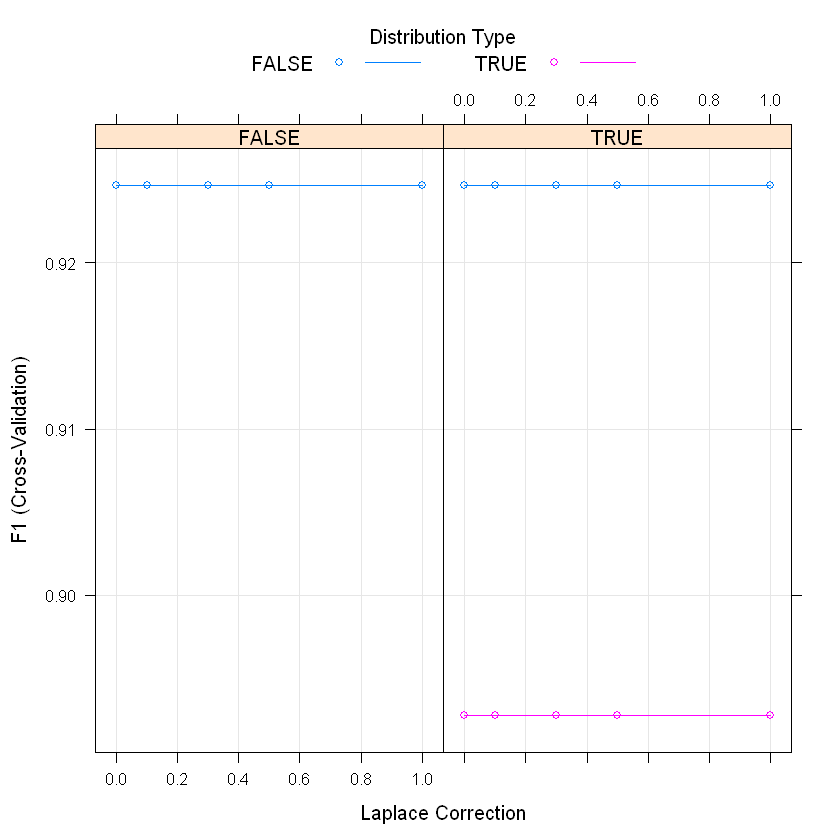

In [61]:
plot(model_nb)

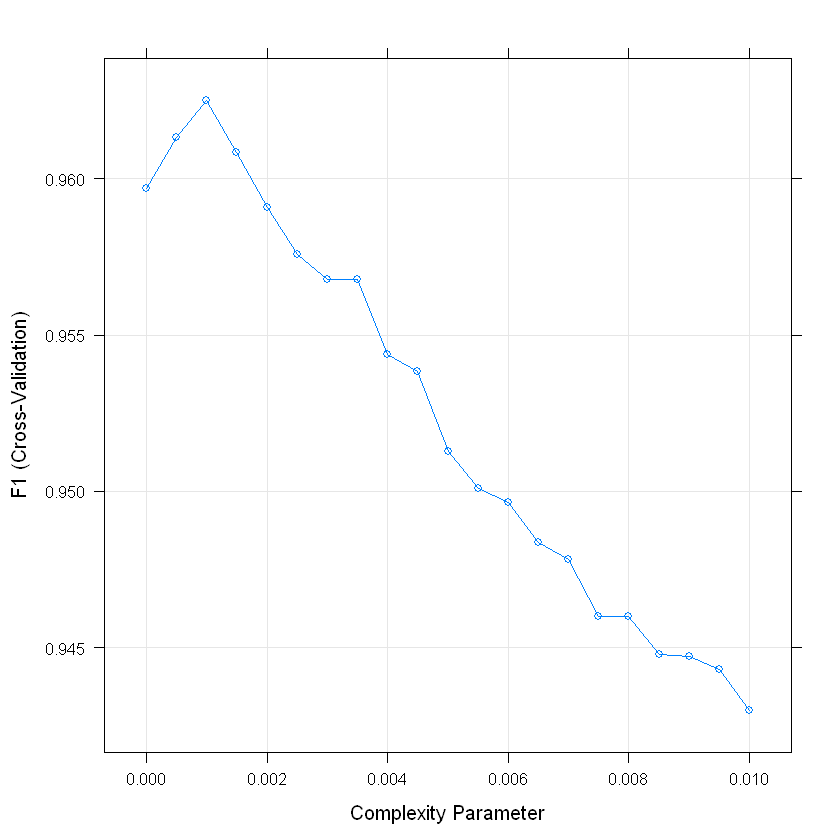

In [62]:
plot(model_rpart)

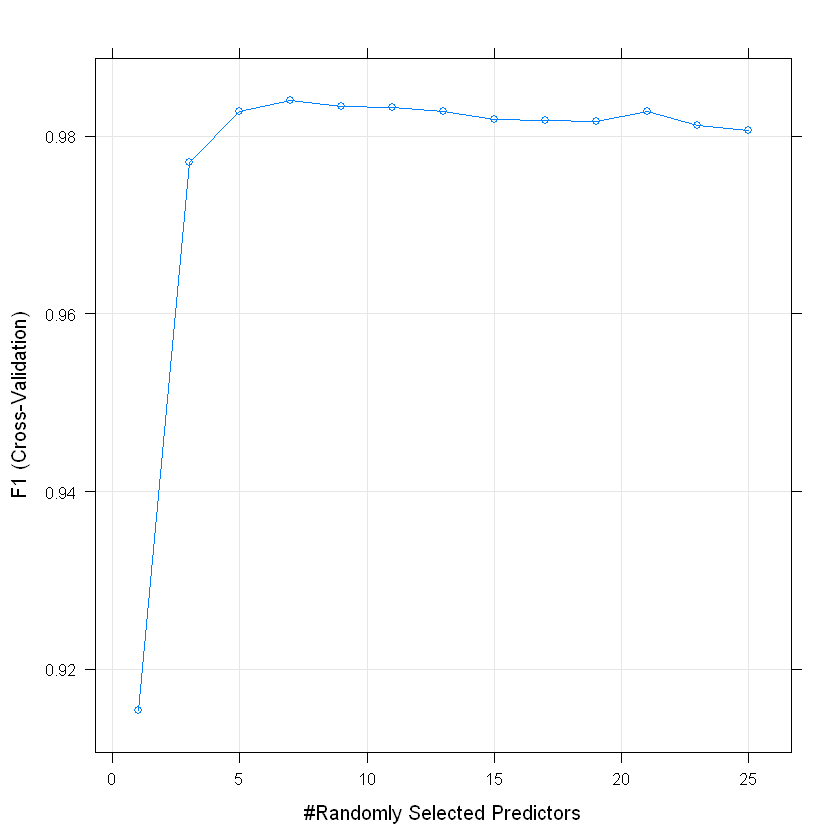

In [63]:
plot(model_rf)

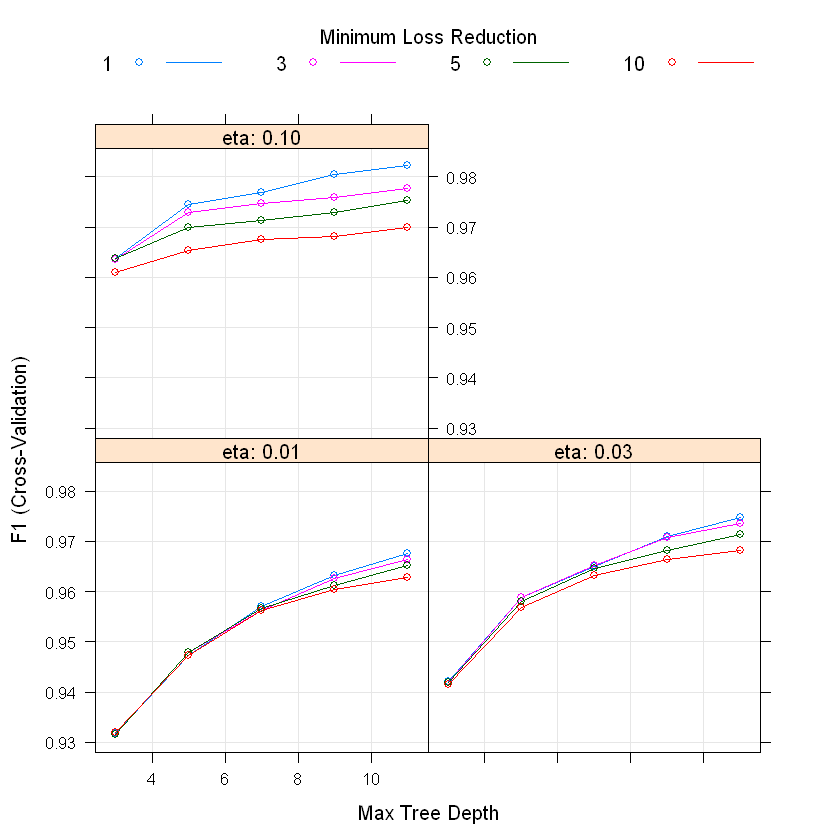

In [60]:
plot(model_xgb)